# Import necessary libraries

In [4]:
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# Feature Extraction for training data

In [4]:
def extract_features(file_path):
    """Extract audio features from .wav file"""
    y, sr = librosa.load(file_path, sr = 16000)

    features = {}
    
    # MFCC Features (20 coefficients)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    delta1 = librosa.feature.delta(mfcc)
    delta2 = librosa.feature.delta(mfcc, order=2)
    
    # Flatten MFCC statistics per coefficient
    for i in range(20):
        features[f'mfcc_mean_{i}'] = np.mean(mfcc[i])
        features[f'mfcc_var_{i}'] = np.var(mfcc[i])
        features[f'mfcc_delta1_mean_{i}'] = np.mean(delta1[i])
        features[f'mfcc_delta2_mean_{i}'] = np.mean(delta2[i])
    
    # Prosodic Features
    f0 = librosa.yin(y, fmin=50, fmax=2000)
    rms = librosa.feature.rms(y=y)
    features.update({
        'pitch_mean': np.mean(f0),
        'pitch_var': np.var(f0),
        'intensity_mean': np.mean(rms),
        'intensity_var': np.var(rms)
    })
    
    # Chroma Features (12 coefficients)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    for i in range(12):
        features[f'chroma_mean_{i}'] = np.mean(chroma[i])
        features[f'chroma_var_{i}'] = np.var(chroma[i])
    return features

In [ ]:
# Verify data folder exists

#run this block to create FeaturesNC.csv training features containing audio features and filename 

if not os.path.exists('data'):
    raise FileNotFoundError("Create 'data' folder with .wav files first")
    
all_features = []

file_count = 0

for file in os.listdir('data'):
    if file.endswith('.wav'):
        file_count += 1
        file_path = os.path.join('data', file)
        features = extract_features(file_path)
        features['filename'] = file
        all_features.append(features)
        print('\r'+f' Processed {file_count}/9054 audio samples ',end='')
    
# Create DataFrame and normalize features ## note that we have used first standard_scaler scaler_std and then used minminax scalaer scaler_mm
df = pd.DataFrame(all_features)
scaler_std = StandardScaler()



numeric_cols = df.columns[df.columns != 'filename']
df[numeric_cols] = scaler_std.fit_transform(df[numeric_cols])
    
# Save to CSV
df.to_csv('FeaturesNC.csv', index=False)
print(f"Saved features for {len(df)} files to audio_features.csv")

# 80 MFCC features
# 4 Prosodic features
# 24 Chroma features
# 108 total features

 Processed 308/9054 audio samples 

c:\python311\Lib\site-packages\librosa\core\pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


 Processed 9054/9054 audio samples Saved features for 9054 files to audio_features.csv


In [6]:
df.head(10)

,mfcc_mean_0,mfcc_var_0,mfcc_delta1_mean_0,mfcc_delta2_mean_0,mfcc_mean_1,mfcc_var_1,mfcc_delta1_mean_1,mfcc_delta2_mean_1,mfcc_mean_2,mfcc_var_2,...,chroma_var_7,chroma_mean_8,chroma_var_8,chroma_mean_9,chroma_var_9,chroma_mean_10,chroma_var_10,chroma_mean_11,chroma_var_11,filename
0,0.834586,1.399231,0.753235,-0.505081,0.218568,-0.587162,0.061760,-1.422399,-0.671230,0.206781,...,0.297602,-0.520531,-0.858451,-0.428056,-2.520287,1.443483,-0.668496,1.681475,0.318244,0_ANG.wav
1,0.391162,0.225413,0.059470,0.184533,0.326994,-0.683399,-0.300575,-0.304913,-0.572738,-0.320606,...,-1.242312,-0.506277,-1.653459,0.374480,-2.295443,1.736757,-1.253047,1.436923,0.165123,0_DIS.wav
2,0.665520,1.589540,0.005620,0.480937,0.290102,-0.790198,-0.362045,-0.463945,-0.687569,0.121826,...,0.111823,0.119390,-0.912072,0.540266,-1.239438,1.350190,-0.528587,-0.055904,-1.170534,0_FEA.wav
3,0.864501,1.278906,0.130343,-0.224298,0.213732,-0.792951,-0.261703,-0.524748,-0.878436,-0.326009,...,-1.012356,-0.635119,-0.875758,0.161979,-0.844698,1.651674,-0.088865,0.754122,0.296912,0_HAP.wav
4,0.510921,-0.054911,0.217223,0.008462,0.482819,-0.705185,-0.341366,0.341044,-0.627766,-0.721862,...,-0.738582,-0.095585,-0.935388,0.923805,-0.674348,0.954961,-1.339392,1.034365,0.746286,0_NEU.wav
5,1.536439,0.392063,3.933534,0.370935,0.329919,-0.401887,-0.762652,0.507211,-0.698775,1.162212,...,-0.126512,-0.542853,1.970552,-0.727460,0.304476,-0.358255,1.493296,-0.648887,-0.660415,1000_ANG.wav
6,-0.085392,-0.973116,0.020525,0.357240,1.066331,-0.763695,-0.454437,-0.358570,1.110866,-0.912511,...,-0.824108,-0.472513,0.117114,-0.111848,0.790364,0.017969,0.952105,-0.332817,-0.104321,1000_DIS.wav
7,0.057879,-0.789480,-0.137088,0.120063,0.934884,-0.626318,-0.292193,-0.447344,1.009380,-0.580292,...,-1.068673,-0.999882,-0.646795,0.509536,1.884646,0.477657,0.336541,0.809978,0.036123,1000_FEA.wav
8,0.796684,-0.397486,-0.088007,1.183175,0.889104,-0.568228,-0.379208,0.084814,-0.185156,0.199186,...,1.536929,-1.101037,-1.047409,-1.125543,-0.934883,-0.395341,1.340407,-0.099846,-0.141414,1000_HAP.wav
9,0.047212,-0.307068,0.420854,0.842951,0.310777,-0.693294,-0.585771,-0.918643,0.168723,0.685779,...,-1.513305,-0.803228,-0.674535,-0.448291,-0.251729,-0.438372,-0.158025,-0.062648,-1.117878,1000_NEU.wav


In [ ]:
# Load the CSV file

#run this code block to convert filenames into emotions and overwrite FeaturesNC.csv

df = pd.read_csv('FeaturesNC.csv')

emotion_map = {
    'ANG': 'anger_emotion',
    'DIS': 'disgust_emotion',
    'FEA': 'fear_emotion',
    'HAP': 'happy_emotion',
    'NEU': 'neutral_emotion',
    'SAD': 'sad_emotion'
}

# Extract the emotion abbreviation from the filename
df['emotion_abbr'] = df['filename'].str.extract('_([A-Z]{3})\.wav')

df['emotion'] = df['emotion_abbr'].map(emotion_map)
df = df.drop('emotion_abbr', axis=1)
df = df.drop('filename', axis = 1)
df.to_csv('FeaturesNC.csv', index=False)

df.head(4)

,mfcc_mean_0,mfcc_var_0,mfcc_delta1_mean_0,mfcc_delta2_mean_0,mfcc_mean_1,mfcc_var_1,mfcc_delta1_mean_1,mfcc_delta2_mean_1,mfcc_mean_2,mfcc_var_2,...,chroma_var_7,chroma_mean_8,chroma_var_8,chroma_mean_9,chroma_var_9,chroma_mean_10,chroma_var_10,chroma_mean_11,chroma_var_11,emotion
0,0.834586,1.399231,0.753235,-0.505081,0.218568,-0.587162,0.061760,-1.422399,-0.671230,0.206781,...,0.297602,-0.520531,-0.858451,-0.428056,-2.520287,1.443483,-0.668496,1.681475,0.318244,anger_emotion
1,0.391162,0.225413,0.059470,0.184533,0.326994,-0.683399,-0.300575,-0.304913,-0.572738,-0.320606,...,-1.242312,-0.506277,-1.653459,0.374480,-2.295443,1.736757,-1.253047,1.436923,0.165123,disgust_emotion
2,0.665520,1.589540,0.005620,0.480937,0.290102,-0.790198,-0.362045,-0.463945,-0.687569,0.121826,...,0.111823,0.119390,-0.912072,0.540266,-1.239438,1.350190,-0.528587,-0.055904,-1.170534,fear_emotion
3,0.864501,1.278906,0.130343,-0.224298,0.213732,-0.792951,-0.261703,-0.524748,-0.878436,-0.326009,...,-1.012356,-0.635119,-0.875758,0.161979,-0.844698,1.651674,-0.088865,0.754122,0.296912,happy_emotion


In [ ]:
df = pd.read_csv("FeaturesNC.csv")

# Separate features and labels
features = df.drop('emotion', axis=1)
labels = df['emotion']

# Normalize features to range [-1, 1] now we are using min_max scaler, and overwrite the FeaturesNC.csv
scaler_mm = MinMaxScaler(feature_range=(-1, 1))
features_normalized = scaler_mm.fit_transform(features)

# Create a new DataFrame with normalized features and original labels
df_normalized = pd.DataFrame(features_normalized, columns=features.columns)
df_normalized['emotion'] = labels

# Save the normalized DataFrame to a new CSV file
df_normalized.to_csv("FeaturesNC.csv", index=False)

print("Features have been successfully normalized to the range [-1, 1].")


## after this, 

Features have been successfully normalized to the range [-1, 1].


##### final FeaturesNC.csv(normalized first using scaler_std, then using scaler_mm)

In [11]:
df = pd.read_csv("FeaturesNC.csv")
df.head(5)
# we have a final FeaturesNC.csv that contains features, with corresponding emotion labels,. features are 
## first normlaized using standard_scaler and then used min_max scaler.

,mfcc_mean_0,mfcc_var_0,mfcc_delta1_mean_0,mfcc_delta2_mean_0,mfcc_mean_1,mfcc_var_1,mfcc_delta1_mean_1,mfcc_delta2_mean_1,mfcc_mean_2,mfcc_var_2,...,chroma_var_7,chroma_mean_8,chroma_var_8,chroma_mean_9,chroma_var_9,chroma_mean_10,chroma_var_10,chroma_mean_11,chroma_var_11,emotion
0,0.636853,-0.048874,0.044086,0.146277,0.248203,-0.835486,-0.257638,-0.386026,0.058731,-0.467257,...,-0.064287,-0.258320,-0.320085,-0.065005,-0.590688,0.463323,-0.108560,0.352855,-0.198628,anger_emotion
1,0.556785,-0.467593,-0.054334,0.275902,0.284652,-0.865644,-0.328883,-0.215610,0.093430,-0.607373,...,-0.472468,-0.255051,-0.520681,0.175866,-0.535555,0.552193,-0.273701,0.285745,-0.242066,disgust_emotion
2,0.606325,0.019012,-0.061973,0.331616,0.272251,-0.899111,-0.340970,-0.239862,0.052975,-0.489828,...,-0.113531,-0.111591,-0.333615,0.225625,-0.276619,0.435052,-0.069035,-0.123916,-0.620972,fear_emotion
3,0.642255,-0.091796,-0.044280,0.199055,0.246577,-0.899973,-0.321240,-0.249134,-0.014268,-0.608808,...,-0.411514,-0.284594,-0.324452,0.112087,-0.179827,0.526411,0.055191,0.098371,-0.204680,happy_emotion
4,0.578410,-0.567589,-0.031955,0.242806,0.337036,-0.872471,-0.336904,-0.117102,0.074044,-0.713978,...,-0.338946,-0.160883,-0.339498,0.340739,-0.138057,0.315286,-0.298095,0.175275,-0.077199,neutral_emotion


# feature extraction for test data

In [ ]:
# Verify data folder exists
if not os.path.exists('test'):
    raise FileNotFoundError("Create 'test' folder with .wav files first")
    
# Process all audio files
all_features = []
file_count = 0

for file in os.listdir('test'):
    if file.endswith('.wav'):
        file_count += 1
        file_path = os.path.join('test', file)
        features = extract_features(file_path)
        features['filename'] = file
        all_features.append(features)
        print('\r'+f' Processed {file_count}/2764 audio samples ',end='')
        
        
    
# Create DataFrame and normalize features
df = pd.DataFrame(all_features)
numeric_cols = df.columns[df.columns != 'filename']
#using the same std_scaler
df[numeric_cols] = scaler_std.fit_transform(df[numeric_cols])
    
# Save to CSV
df.to_csv('audio_features_test.csv', index=False)
print(f"Saved features for {len(df)} files to audio_features_test.csv")
# 80 MFCC features
# 4 Prosodic features
# 24 Chroma features
# 108 total features

 Processed 2764/2764 audio samples Saved features for 2764 files to audio_features.csv


In [ ]:
df = pd.read_csv("audio_features_test.csv")
# Separate features and labels
features = df.drop('filename', axis=1)
file_col = df['filename']

#use the same scalar_mm
features_normalized = scaler_mm.fit_transform(features)

# Create a new DataFrame with normalized features and original labels
df_normalized = pd.DataFrame(features_normalized, columns=features.columns)
df_normalized['filename'] = file_col

# Save the normalized DataFrame to a new CSV file (optional)
df_normalized.to_csv("audio_features_test.csv", index=False)

print("Features have been successfully normalized to the range [-1, 1].")
##  now we have extracted features for test files, normalized first using scaler_std and then using scaler_mm 

Features have been successfully normalized to the range [-1, 1].


# seperate feature for each emotion for further analysis

In [14]:
# Read the CSV file

#run this code block to sperate FeaturesNC.csv emotion wise.

df = pd.read_csv('FeaturesNC.csv')

# Get unique emotions
emotions = df['emotion'].unique()

# Create separate CSV files for each emotion
for emotion in emotions:
    emotion_df = df[df['emotion'] == emotion]
    emotion_df.to_csv(f'{emotion}_features.csv', index=False)
    print(f"Created {emotion}_features.csv")

Created anger_emotion_features.csv
Created disgust_emotion_features.csv
Created fear_emotion_features.csv
Created happy_emotion_features.csv
Created neutral_emotion_features.csv
Created sad_emotion_features.csv


# Exploratory Data Analysis

Heatmap

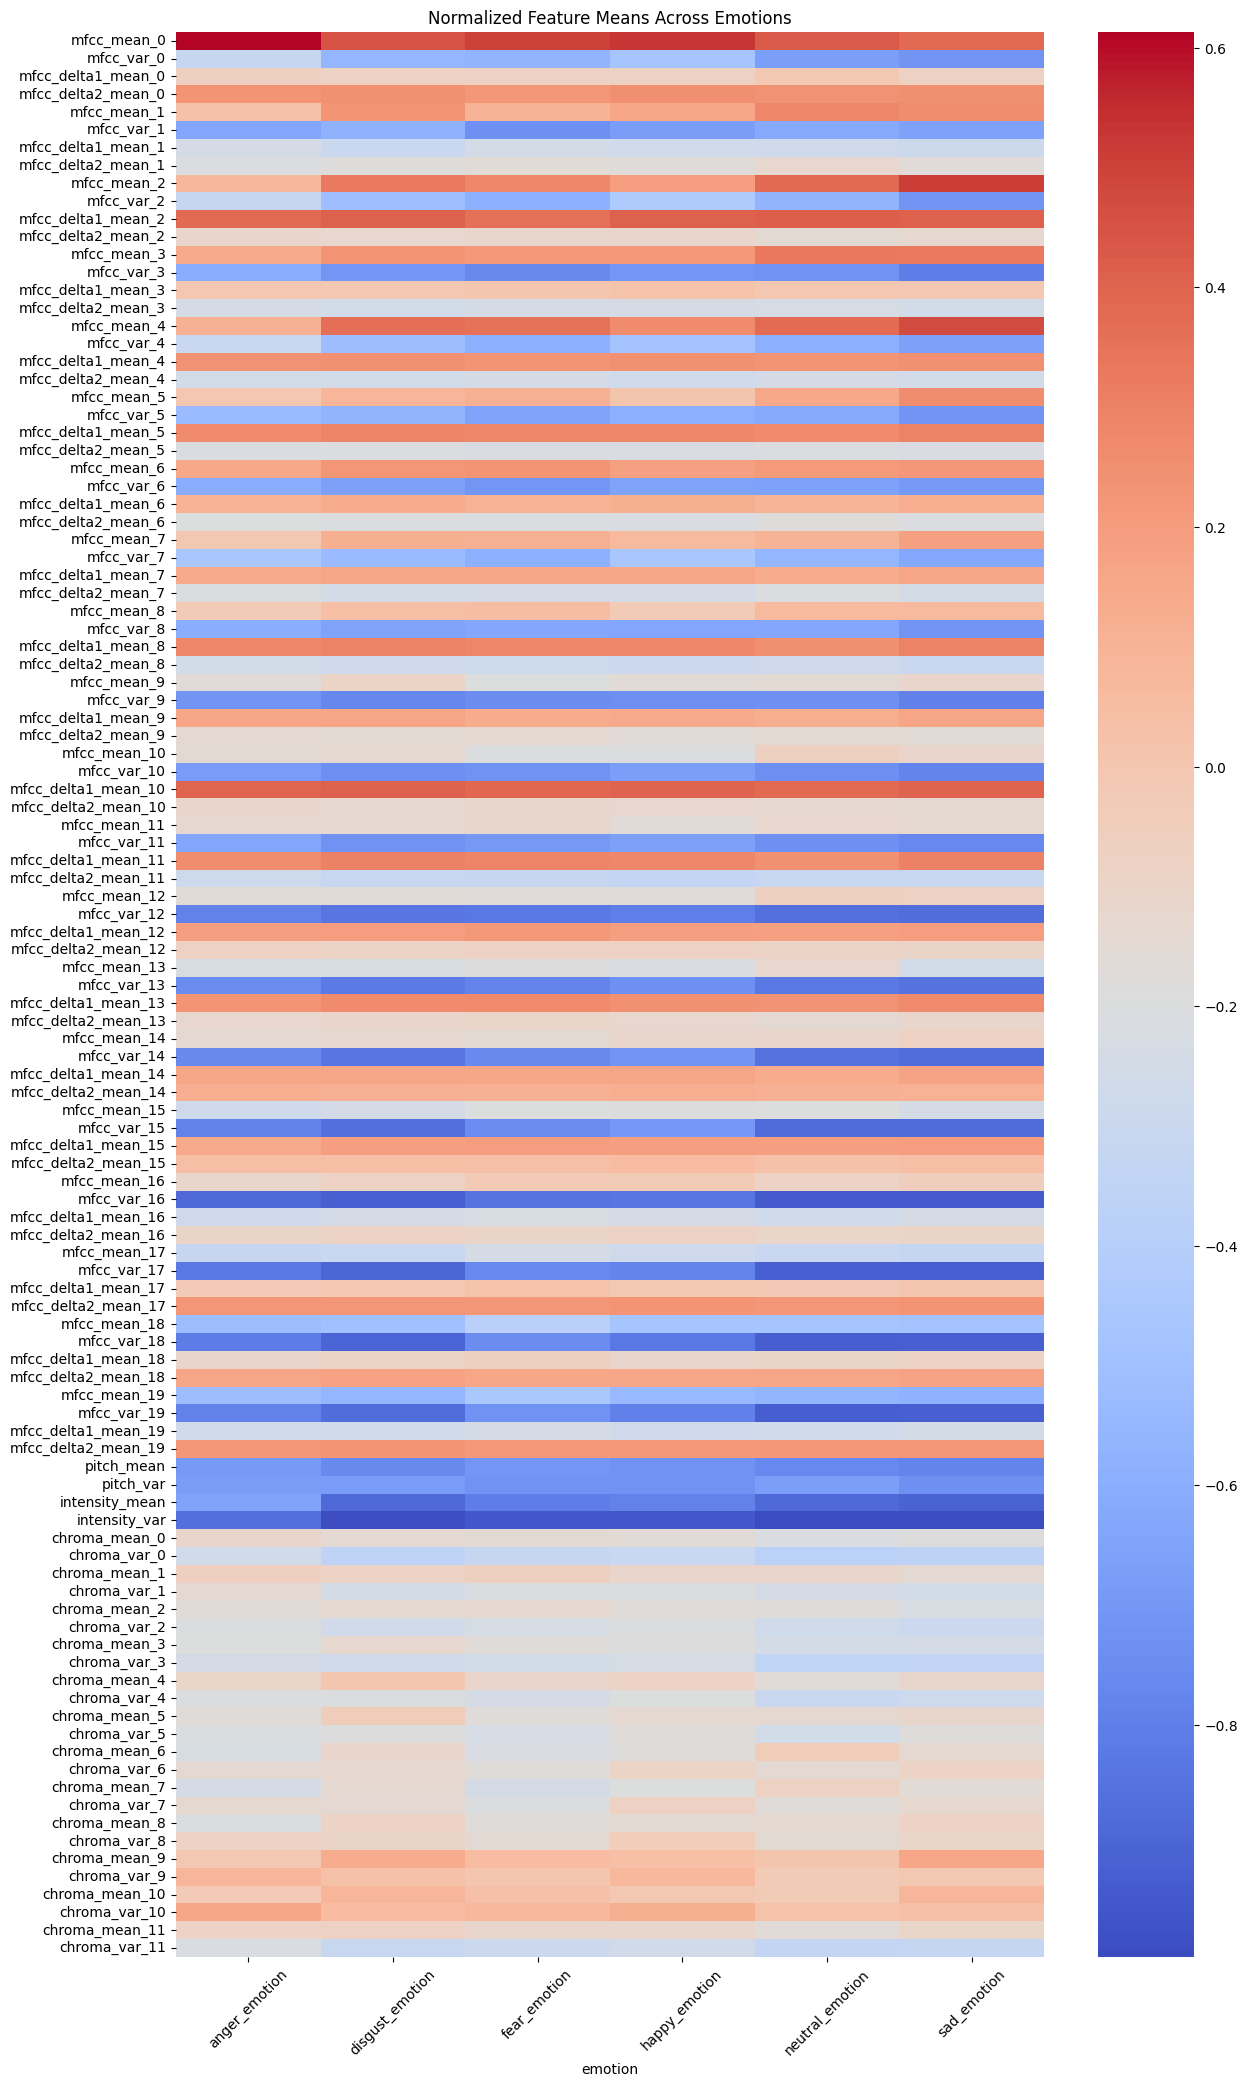

In [15]:
# Load data and ensure numeric types
df = pd.read_csv('FeaturesNC.csv')

numeric_features = df.select_dtypes(include=['number']).columns.tolist()
numeric_features = [f for f in numeric_features if f not in ['emotion']]

# Fix 2: Use numeric_only in mean calculation
emotion_means = df.groupby('emotion')[numeric_features].mean()

# Plot heatmap
plt.figure(figsize=(14, 25))
sns.heatmap(emotion_means.T, cmap='coolwarm', annot=False, 
            xticklabels=emotion_means.index, yticklabels=emotion_means.columns)
plt.title('Normalized Feature Means Across Emotions')
plt.xticks(rotation=45)
plt.show()


significant_features = []
for feature in numeric_features:
    try:
        groups = [df[df['emotion'] == e][feature].dropna() 
                for e in df['emotion'].unique()]
        f_val, p_val = f_oneway(*groups)
        if p_val < 0.05:
            significant_features.append(feature)
    except:
        continue


Correlation Matrix

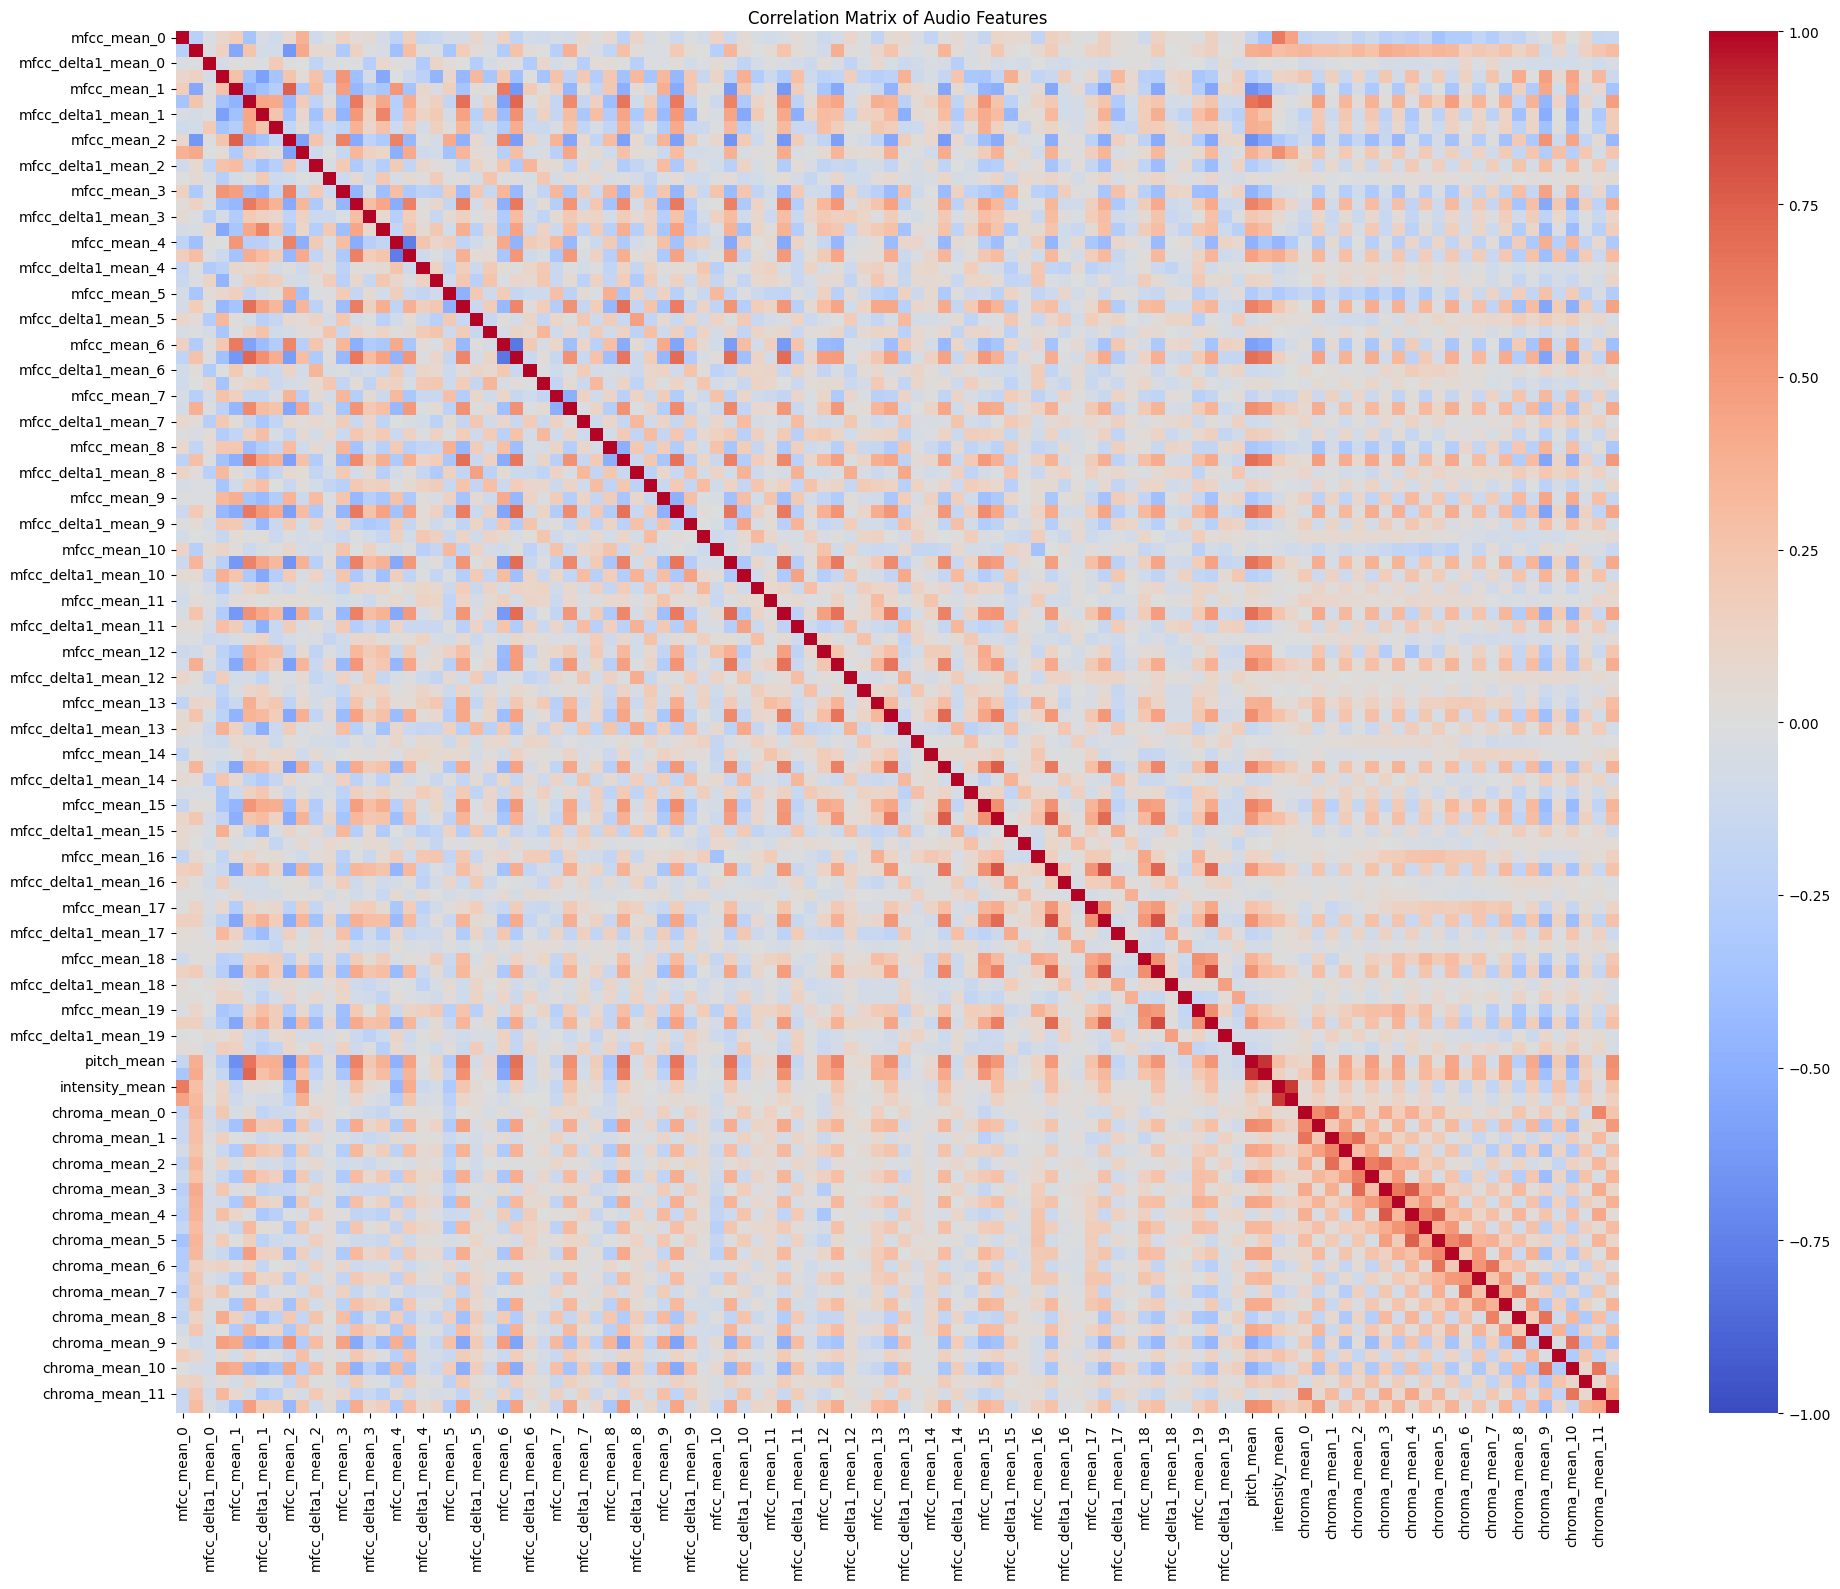

                    mfcc_mean_0  mfcc_var_0  mfcc_delta1_mean_0   
mfcc_mean_0            1.000000   -0.244731           -0.027711  \
mfcc_var_0            -0.244731    1.000000           -0.023045   
mfcc_delta1_mean_0    -0.027711   -0.023045            1.000000   
mfcc_delta2_mean_0     0.099140    0.138682           -0.062942   
mfcc_mean_1            0.185255   -0.542845            0.014835   
...                         ...         ...                 ...   
chroma_var_9           0.185565    0.101271           -0.082559   
chroma_mean_10        -0.001488   -0.064256           -0.079080   
chroma_var_10          0.117440    0.145287           -0.043184   
chroma_mean_11        -0.149672    0.241503           -0.096752   
chroma_var_11         -0.145404    0.304418           -0.046390   

                    mfcc_delta2_mean_0  mfcc_mean_1  mfcc_var_1   
mfcc_mean_0                   0.099140     0.185255   -0.357536  \
mfcc_var_0                    0.138682    -0.542845    0.2491

In [16]:
# Load the data (assuming you've already done this)
df = pd.read_csv('FeaturesNC.csv')

# Ensure all feature columns are numeric
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Compute the correlation matrix
corr_matrix = df[numeric_cols].corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix of Audio Features')
plt.tight_layout()
plt.show()

# If you want to see the actual correlation values, you can print them:
print(corr_matrix)

# To find the most correlated features with the emotion label (assuming it's numeric):
if 'emotion' in numeric_cols:
    emotion_correlations = corr_matrix['emotion'].sort_values(ascending=False)
    print("\nTop 10 features correlated with emotion:")
    print(emotion_correlations.head(10))
    print("\nBottom 10 features correlated with emotion:")
    print(emotion_correlations.tail(10))
else:
    print("\nEmotion label is not numeric. Consider encoding it for correlation analysis.")


Variance Across Emotions

In [17]:
import pandas as pd
import numpy as np

# List of emotion CSV files
emotion_files = ['anger_emotion_features.csv', 'disgust_emotion_features.csv', 'fear_emotion_features.csv', 
                 'happy_emotion_features.csv', 'neutral_emotion_features.csv', 'sad_emotion_features.csv']


emotion_dfs = {}


for file in emotion_files:
    emotion = file.split('_')[0]
    emotion_dfs[emotion] = pd.read_csv(file)

# Get list of features (excluding 'filename' and 'emotion' columns)
features = [col for col in emotion_dfs[list(emotion_dfs.keys())[0]].columns 
            if col not in ['filename', 'emotion']]


variance_data = {}
for emotion, df in emotion_dfs.items():
    variance_data[emotion] = df[features].var()


variance_df = pd.DataFrame(variance_data)


print(variance_df)

# Optionally, save the variance table to a CSV file
variance_df.to_csv('feature_variance_by_emotion.csv')


                       anger   disgust      fear     happy   neutral       sad
mfcc_mean_0         0.026964  0.025369  0.026002  0.026812  0.028135  0.029588
mfcc_var_0          0.121350  0.122218  0.122463  0.109638  0.075483  0.106063
mfcc_delta1_mean_0  0.028108  0.012633  0.025290  0.018251  0.026826  0.007767
mfcc_delta2_mean_0  0.056857  0.023162  0.045880  0.031355  0.036928  0.017542
mfcc_mean_1         0.127394  0.077197  0.136522  0.130118  0.082148  0.074617
...                      ...       ...       ...       ...       ...       ...
chroma_var_9        0.048552  0.053192  0.071072  0.048796  0.050668  0.076260
chroma_mean_10      0.051893  0.063808  0.113531  0.064849  0.137289  0.110417
chroma_var_10       0.059772  0.073830  0.088286  0.068628  0.079465  0.095633
chroma_mean_11      0.051019  0.058163  0.078818  0.054728  0.122592  0.087263
chroma_var_11       0.072204  0.066654  0.083662  0.073625  0.086514  0.090887

[108 rows x 6 columns]


In [18]:
# Read the CSV file
df = pd.read_csv('feature_variance_by_emotion.csv', index_col=0)

# Function to get top N features for an emotion
def get_top_features(emotion_variances, n=5):
    return emotion_variances.nlargest(n).index.tolist()

# Number of top features to extract
N = 5

# Dictionary to store top features for each emotion
top_features = {}

# Extract top N features for each emotion
for emotion in df.columns:
    top_features[emotion] = get_top_features(df[emotion], N)

# Print top features for each emotion
for emotion, features in top_features.items():
    print(f"\nTop {N} features for {emotion}:")
    for i, feature in enumerate(features, 1):
        variance = df.loc[feature, emotion]
        print(f"{i}. {feature} (Variance: {variance:.4f})")

# Optional: Find common important features across all emotions
common_features = set(top_features[list(top_features.keys())[0]])
for features in top_features.values():
    common_features = common_features.intersection(set(features))

print(f"\nCommon important features across all emotions:")
print(', '.join(common_features) if common_features else "No common features found")



Top 5 features for anger:
1. mfcc_var_4 (Variance: 0.1282)
2. mfcc_mean_1 (Variance: 0.1274)
3. mfcc_var_0 (Variance: 0.1214)
4. pitch_var (Variance: 0.1151)
5. mfcc_mean_2 (Variance: 0.0955)

Top 5 features for disgust:
1. mfcc_var_1 (Variance: 0.1640)
2. pitch_var (Variance: 0.1587)
3. mfcc_var_5 (Variance: 0.1223)
4. mfcc_var_0 (Variance: 0.1222)
5. mfcc_var_4 (Variance: 0.1080)

Top 5 features for fear:
1. mfcc_mean_2 (Variance: 0.1543)
2. pitch_var (Variance: 0.1392)
3. mfcc_mean_1 (Variance: 0.1365)
4. mfcc_var_19 (Variance: 0.1272)
5. mfcc_var_0 (Variance: 0.1225)

Top 5 features for happy:
1. mfcc_mean_1 (Variance: 0.1301)
2. mfcc_mean_2 (Variance: 0.1110)
3. mfcc_var_0 (Variance: 0.1096)
4. chroma_var_5 (Variance: 0.1065)
5. pitch_var (Variance: 0.0988)

Top 5 features for neutral:
1. pitch_var (Variance: 0.2090)
2. chroma_mean_10 (Variance: 0.1373)
3. chroma_mean_9 (Variance: 0.1269)
4. chroma_mean_11 (Variance: 0.1226)
5. chroma_mean_6 (Variance: 0.1179)

Top 5 features for

# Dimensionality Reduction (PCA 66 for k-means , PCA 10 for DBSCAN)

Principle Component Analysis

In [19]:
# Load data
df = pd.read_csv('featuresNC.csv')
# Separate features and labels
X = df.drop(['emotion'], axis=1)  # Features
y = df['emotion'] # Labels



In [20]:
# Initialize PCA (retain 95% variance)
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X)
# Get explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()
# Print variance information
print(f"Reduced dimensions: {X_pca.shape[1]}")
print(f"Variance retained: {cumulative_variance[-1]:.2%}")

Reduced dimensions: 66
Variance retained: 95.09%


In [21]:
# Load the original data
df = pd.read_csv('featuresNC.csv')
# Separate features and labels
X = df.drop(['emotion'], axis=1)
y = df['emotion']

# Apply PCA
pca = PCA(n_components=66)
X_pca = pca.fit_transform(X)
# Create a new DataFrame with reduced features
pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(66)])
# Add filename and emotion columns back to the DataFrame
pca_df['emotion'] = y
# Save the new DataFrame to a CSV file
pca_df.to_csv('featureNC_pca66.csv', index=False)
print("Created featureNC_pca66.csv with 66 PCA components.")


Created featureNC_pca66.csv with 66 PCA components.


In [22]:
# Load the original data
df = pd.read_csv('featuresNC.csv')
# Separate features and labels
X = df.drop(['emotion'], axis=1)
y = df['emotion']

# already Standardized features
#  PCA
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X)

# Create a new DataFrame with reduced features
pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(10)])

# Add filename and emotion columns back to the DataFrame
pca_df['emotion'] = y

# Save the new DataFrame to a CSV file
pca_df.to_csv('featureNC_pca10.csv', index=False)

print("Created featureNC_pca10.csv with 10 PCA components.")


Created featureNC_pca10.csv with 10 PCA components.


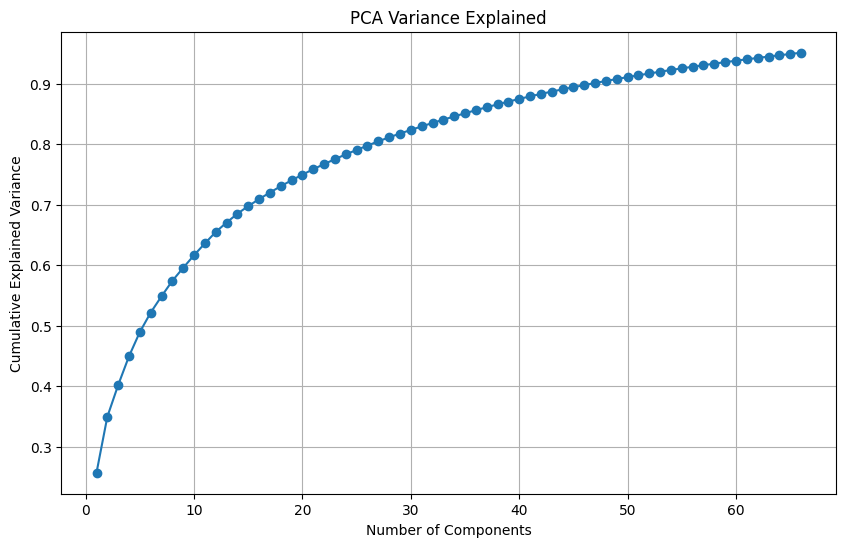

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Variance Explained')
plt.grid(True)
plt.show()

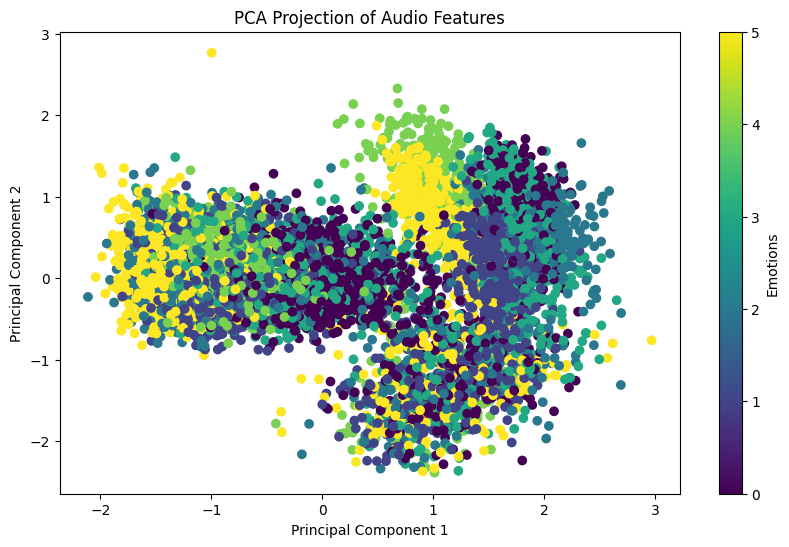

In [24]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y.factorize()[0], cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Projection of Audio Features')
plt.colorbar(scatter, ticks=range(len(y.unique())), label='Emotions')
plt.show()

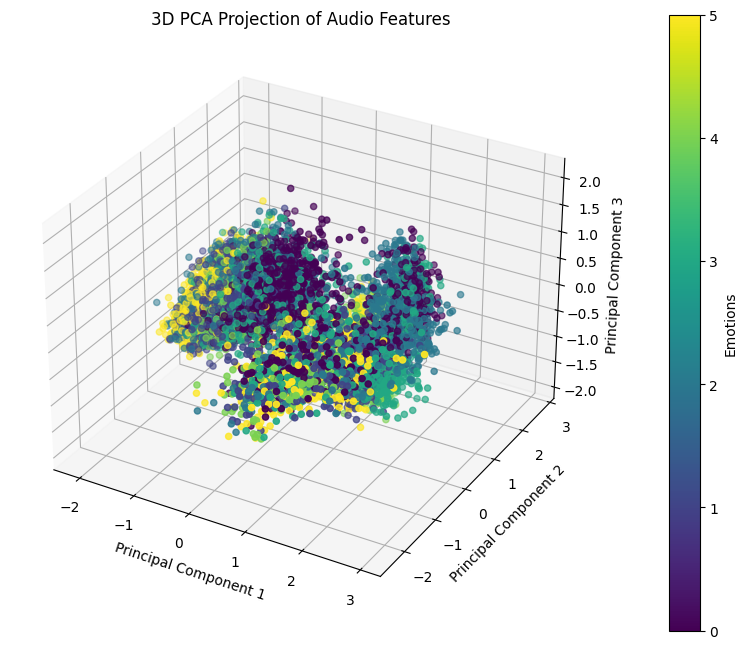

In [25]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Make sure X_pca has at least 3 components
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],
    c=y.factorize()[0],
    cmap='viridis'
)

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D PCA Projection of Audio Features')

cbar = plt.colorbar(scatter, ticks=range(len(y.unique())), pad=0.1)
cbar.set_label('Emotions')

plt.show()


In [26]:

pca_df = pd.DataFrame(X_pca, columns=[f'PC{i}' for i in range(1, X_pca.shape[1]+1)])
pca_df['emotion'] = y


component_stats = pca_df.groupby('emotion').mean()
print("Component Means by Emotion:")
print(component_stats)

Component Means by Emotion:
                      PC1       PC2       PC3       PC4       PC5       PC6   
emotion                                                                       
anger_emotion    0.467467 -0.006325  0.386062 -0.145531  0.040024 -0.085582  \
disgust_emotion -0.104797 -0.180084 -0.087537  0.023846 -0.014981 -0.041980   
fear_emotion     0.012488  0.047338  0.117736  0.068822  0.082311  0.209436   
happy_emotion    0.233497 -0.025707  0.116441 -0.092387  0.139507 -0.019710   
neutral_emotion -0.180044  0.137779 -0.261942  0.093105 -0.135291 -0.011029   
sad_emotion     -0.444307  0.041199 -0.295783  0.062724 -0.123201 -0.048852   

                      PC7       PC8       PC9      PC10  
emotion                                                  
anger_emotion   -0.224121  0.025959 -0.047624  0.024384  
disgust_emotion -0.021192 -0.042290 -0.070190  0.075891  
fear_emotion     0.157870  0.105926  0.107734 -0.021330  
happy_emotion   -0.006716  0.026445  0.035543 -0.

In [27]:
# Get most influential original features for PC1
loadings = pd.DataFrame(pca.components_.T, columns=pca_df.columns[:-1], index=X.columns)
top_pc1_features = loadings['PC1'].abs().nlargest(5).index.tolist()
print("Top 5 Features Influencing PC1:", top_pc1_features)

Top 5 Features Influencing PC1: ['pitch_var', 'mfcc_mean_2', 'mfcc_mean_1', 'mfcc_var_1', 'chroma_mean_9']


# K-Means Clustering

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score
import seaborn as sns

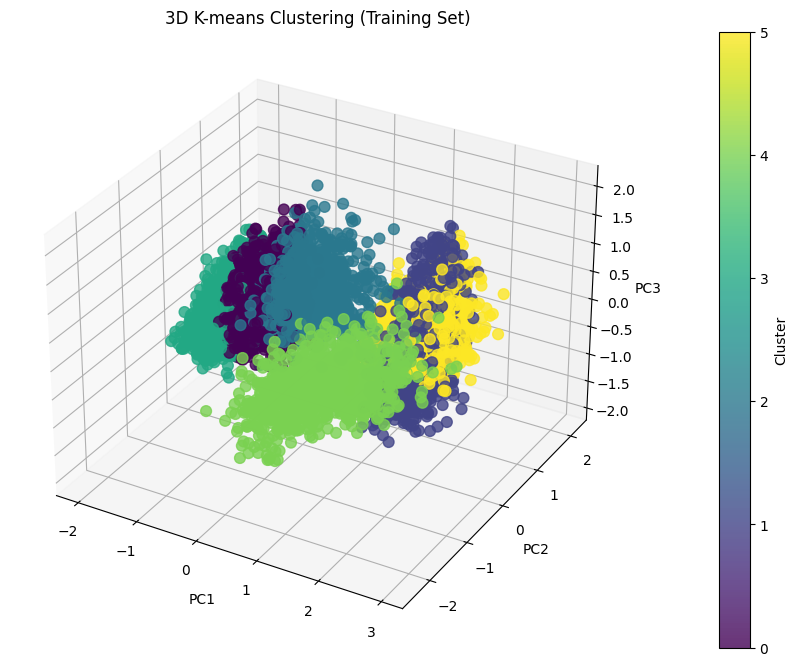

In [16]:
#  reduced dataset
df = pd.read_csv('FeatureNC_pca66.csv')

# PCA features
X = df.filter(regex='^PC')  
y = df['emotion']

## train test split 80-20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


# K-means clustering with k=6 (for 6 emotion categories)
kmeans = KMeans(n_clusters=6, random_state=42)
train_clusters = kmeans.fit_predict(X_train)
test_clusters = kmeans.predict(X_test)

# Add cluster labels to dataframe
train_df = X_train.copy()
train_df['emotion'] = y_train.values
train_df['cluster'] = train_clusters


test_df = X_test.copy()
test_df['emotion'] = y_test.values
test_df['cluster'] = test_clusters


#train_df , test_df contains first extracted features, then its true emotion label and its clustere id
# train_df.to_csv("train_clustered.csv", index = False)
# test_df.to_csv("test_clustered.csv", index = False)


# Visualization using first 2 principal components
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    train_df['PC1'], train_df['PC2'], train_df['PC3'],
    c=train_df['cluster'], cmap='viridis', s=60, alpha=0.8
)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D K-means Clustering (Training Set)')
cbar = plt.colorbar(scatter, pad=0.1)
cbar.set_label('Cluster')
plt.show()


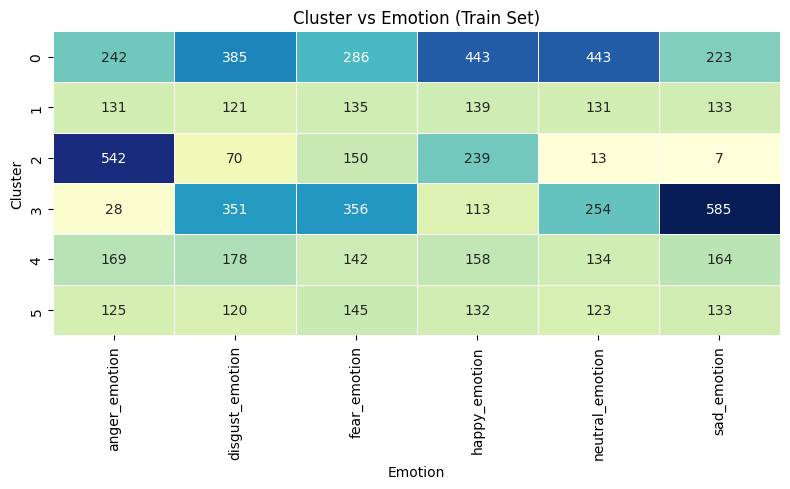

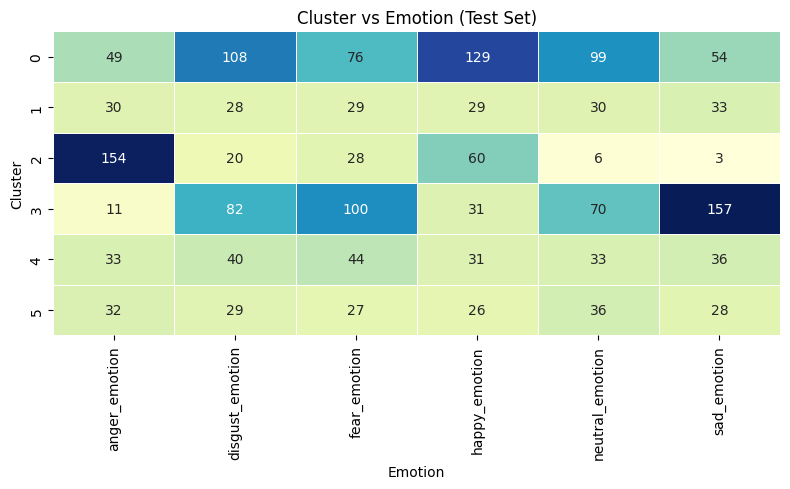

In [17]:

def plot_crosstab_heatmap(df, cluster_col, emotion_col, title):
    ct = pd.crosstab(df[cluster_col], df[emotion_col])
    plt.figure(figsize=(8, 5))
    sns.heatmap(ct, annot=True, fmt='d', cmap='YlGnBu', cbar=False, linewidths=.5)
    plt.title(title)
    plt.xlabel('Emotion')
    plt.ylabel('Cluster')
    plt.tight_layout()
    plt.show()

# Display for Train and Test
plot_crosstab_heatmap(train_df, 'cluster', 'emotion', 'Cluster vs Emotion (Train Set)')
plot_crosstab_heatmap(test_df, 'cluster', 'emotion', 'Cluster vs Emotion (Test Set)')

In [ ]:
#assigning cluster to emotion and saving the results of train clusters and test clusters

# Count frequency of each emotion in each cluster
cluster_label_mapping = (
    train_df.groupby('cluster')['emotion']
    .value_counts()
    .groupby(level=0)
    .idxmax()
    .apply(lambda x: x[1]) 
)

cluster_to_emotion = cluster_label_mapping.to_dict()

cluster_to_emotion[0] = 'neutral_emotion'

for cluster_id, emotion in cluster_to_emotion.items():
    print(f"Cluster {cluster_id} → Emotion: {emotion}")

##since for cluster 0 emotion count for neutral and happy are the same, and for cluster 1 happy count > neutral count, so we can assing cluster 0 as neutral 

train_df1 = train_df[['emotion', 'cluster']].copy()
test_df1 = test_df[['emotion', 'cluster']].copy()

def mapId(id):
    return cluster_to_emotion[id]

train_df1['predicted_label'] = train_df1['cluster'].apply(mapId)
test_df1['predicted_label'] = test_df1['cluster'].apply(mapId)

train_df1.to_csv("predicted_labels_train.csv", index=False)
test_df1.to_csv("predicted labels_test.csv", index = False)

Cluster 0 → Emotion: neutral_emotion
Cluster 1 → Emotion: happy_emotion
Cluster 2 → Emotion: anger_emotion
Cluster 3 → Emotion: sad_emotion
Cluster 4 → Emotion: disgust_emotion
Cluster 5 → Emotion: fear_emotion


In [ ]:
train_df1.head(4)

,emotion,cluster,predicted_label
2300,happy_emotion,3,sad_emotion
6438,anger_emotion,0,neutral_emotion
2551,neutral_emotion,1,happy_emotion
2384,sad_emotion,4,disgust_emotion


In [25]:
test_df1.head(4)

,emotion,cluster,predicted_label
2784,anger_emotion,4,disgust_emotion
1238,disgust_emotion,3,sad_emotion
60,disgust_emotion,3,sad_emotion
2881,happy_emotion,1,happy_emotion


In [ ]:
## train ,test accuracy, ari

from sklearn.metrics import adjusted_rand_score, accuracy_score

# Assuming your DataFrame is called df and has columns 'emotion' and 'predicted'
ari = adjusted_rand_score(train_df1['emotion'], train_df1['predicted_label'])
accuracy = accuracy_score(train_df1['emotion'], train_df1['predicted_label'])
print(f"(Train) Adjusted Rand Index (ARI): {ari:.4f}")
print(f"(Train) Accuracy: {accuracy*100:.2f}%")

ari = adjusted_rand_score(test_df1['emotion'], test_df1['predicted_label'])
accuracy = accuracy_score(test_df1['emotion'], test_df1['predicted_label'])
print(f"(Test) Adjusted Rand Index (ARI): {ari:.4f}")
print(f"(Test) Accuracy: {accuracy*100:.2f}%")


(Train) Adjusted Rand Index (ARI): 0.0574
(Train) Accuracy: 28.05%
(Test) Adjusted Rand Index (ARI): 0.0685
(Test) Accuracy: 27.94%


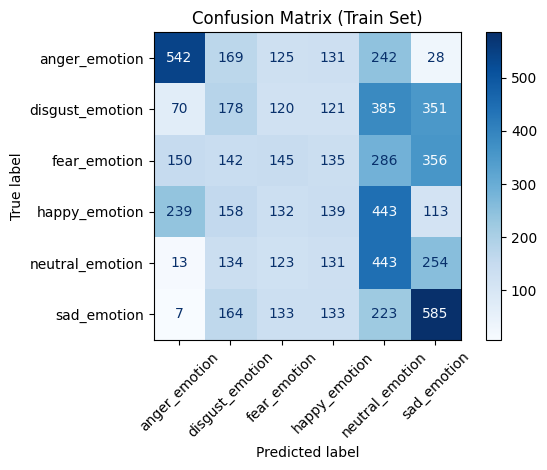

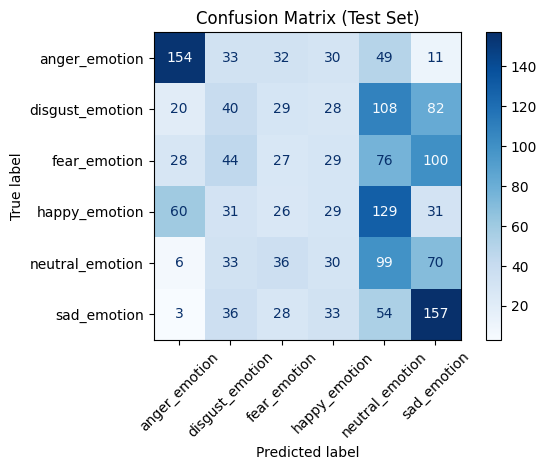

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion matrix for Train
cm_train = confusion_matrix(train_df1['emotion'], train_df1['predicted_label'], labels=sorted(train_df1['emotion'].unique()))
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=sorted(train_df1['emotion'].unique()))
disp_train.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix (Train Set)")
plt.tight_layout()
plt.show()

# Confusion matrix for Test
cm_test = confusion_matrix(test_df1['emotion'], test_df1['predicted_label'], labels=sorted(test_df1['emotion'].unique()))
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=sorted(test_df1['emotion'].unique()))
disp_test.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix (Test Set)")
plt.tight_layout()
plt.show()


In [33]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Adjusted Rand Index (ARI)
ari_train = adjusted_rand_score(y_train_encoded, train_clusters)
ari_test = adjusted_rand_score(y_test_encoded, test_clusters)

print(f"\nAdjusted Rand Index (Train): {ari_train:.8f}")
print(f"Adjusted Rand Index (Test): {ari_test:.8f}")



Adjusted Rand Index (Train): 0.05741939
Adjusted Rand Index (Test): 0.06849082


# DBSCAN from Scratch

In [5]:
def dbscan_from_scratch(X, eps, min_samples):
    """DBSCAN implementation from scratch with Euclidean distance"""
    n = X.shape[0]  # Fix shape access
    visited = np.zeros(n, dtype=bool)
    labels = np.full(n, -1)
    cluster_id = 0
    
    # Precompute distance matrix
    distance_matrix = np.zeros((n, n), dtype=np.float32)
    for i in range(n):
        for j in range(i+1, n):
            dist = np.sqrt(np.sum((X[i] - X[j])**2))
            distance_matrix[i][j] = dist
            distance_matrix[j][i] = dist

    def expand_cluster(point_id, neighbors):
        """Recursively expand cluster"""
        for neighbor in neighbors:
            if not visited[neighbor]:
                visited[neighbor] = True
                new_neighbors = np.where(distance_matrix[neighbor] <= eps)[0]
                
                if len(new_neighbors) >= min_samples:
                    neighbors = np.unique(np.concatenate([neighbors, new_neighbors]))
            
            if labels[neighbor] == -1:
                labels[neighbor] = cluster_id

    for i in range(n):
        if not visited[i]:
            visited[i] = True
            neighbors = np.where(distance_matrix[i] <= eps)[0]
            
            if len(neighbors) < min_samples:
                labels[i] = -1
            else:
                labels[i] = cluster_id
                expand_cluster(i, neighbors)
                cluster_id += 1
                
    return labels

# Load data (ensure correct path)


DBSCAN Results:
- Number of clusters: 400
- Noise points: 61

- ARI (Train): 0.0252
- ARI (Test): 0.0232



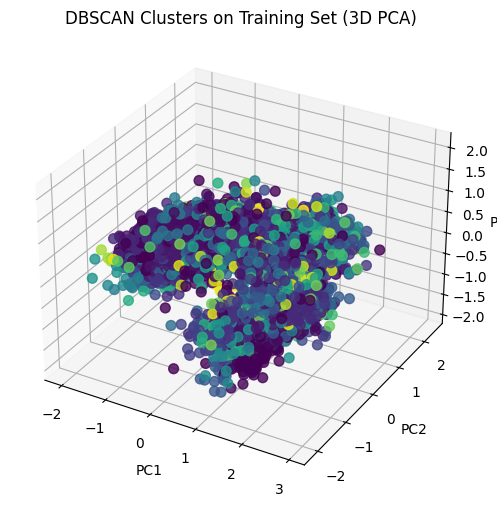

In [ ]:


df = pd.read_csv("featureNC_pca10.csv")

X = df.drop('emotion', axis=1).values
X = np.array(X, dtype=np.float32)
y = df['emotion'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Cluster with parameters
eps = 1
min_samples = 6



train_preds = dbscan_from_scratch(X_train, eps, min_samples)
train_ari = adjusted_rand_score(y_train, train_preds)

test_preds = dbscan_from_scratch(X_test, eps, min_samples)
test_ari = adjusted_rand_score(y_test, test_preds)

print(f"""
DBSCAN Results:
- Number of clusters: {len(set(train_preds)) - (1 if -1 in train_preds else 0)}
- Noise points: {list(train_preds).count(-1)}

- ARI (Train): {train_ari:.4f}
- ARI (Test): {test_ari:.4f}
""")

# 3D Visualization
pca = PCA(n_components=3)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)


fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_train_pca[:, 0], X_train_pca[:, 1], X_train_pca[:, 2],
                     c=train_preds, cmap='viridis', s=50, alpha=0.8)
ax.set_title('DBSCAN Clusters on Training Set (3D PCA)')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()




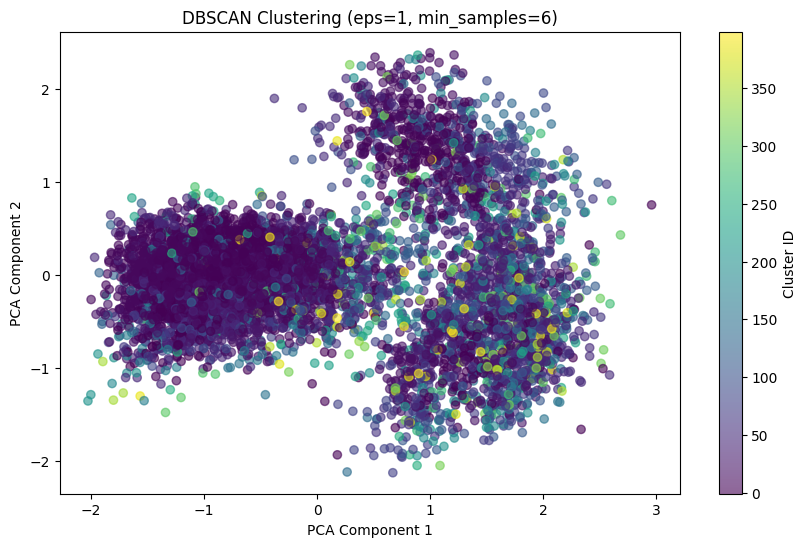

In [10]:

# Visualization using PCA 2d
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)
plt.figure(figsize=(10,6))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=train_preds, cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Cluster ID')
plt.title(f'DBSCAN Clustering (eps={eps}, min_samples={min_samples})')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()